In [1]:
# import packages
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

In [91]:
# read in train and test data
train_df = pd.read_csv(r"E:\github_repos\PRIVATE\Private_Active_Projects\post_HCT_survival_analysis\data\train.csv")
test_df = pd.read_csv(r"E:\github_repos\PRIVATE\Private_Active_Projects\post_HCT_survival_analysis\data\test.csv")

In [92]:
# First thing for this analysis, lets drop any columns from train not in test, easier for now
main_ivs = ['efs','efs_time']   # Replace with your actual column name
columns_to_drop_from_train = [col for col in train_df.columns if col not in test_df.columns and col not in main_ivs]
train_df = train_df.drop(columns_to_drop_from_train)


In [93]:
# Also lets clean the column names, Replace spaces and special characters with underscores or a valid character
train_df.columns = train_df.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)
test_df.columns = test_df.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)

In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [95]:
train_df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [96]:
train_df.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,...,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,...,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,...,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,...,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,...,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [97]:
train_df.dtypes.value_counts()

object     35
float64    23
int64       2
dtype: int64

In [98]:
print(train_df.isnull().mean() * 100)

ID                         0.000000
dri_score                  0.534722
psych_disturb              7.159722
cyto_score                28.013889
diabetes                   7.357639
hla_match_c_high          16.041667
hla_high_res_8            20.239583
tbi_status                 0.000000
arrhythmia                 7.645833
hla_low_res_6             11.354167
graft_type                 0.000000
vent_hist                  0.899306
renal_issue                6.649306
pulm_severe                7.413194
prim_disease_hct           0.000000
hla_high_res_6            18.347222
cmv_status                 2.201389
hla_high_res_10           24.871528
hla_match_dqb1_high       18.052083
tce_imm_match             38.656250
hla_nmdp_6                14.572917
hla_match_c_low            9.722222
rituximab                  7.458333
hla_match_drb1_low         9.177083
hla_match_dqb1_low        14.562500
prod_type                  0.000000
cyto_score_detail         41.399306
conditioning_intensity    16

In [99]:
missing_percentage = train_df.isnull().mean() * 100
train_df_filtered = train_df.loc[:, missing_percentage < 20]
test_df_filtered = test_df[train_df_filtered.columns.intersection(test_df.columns)] # grab variables shared in common with the filtered df

In [100]:
# Okay, lets set up a way to split numeric from categorical 
numeric_columns = train_df_filtered.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df_filtered.select_dtypes(include=['object', 'category']).columns

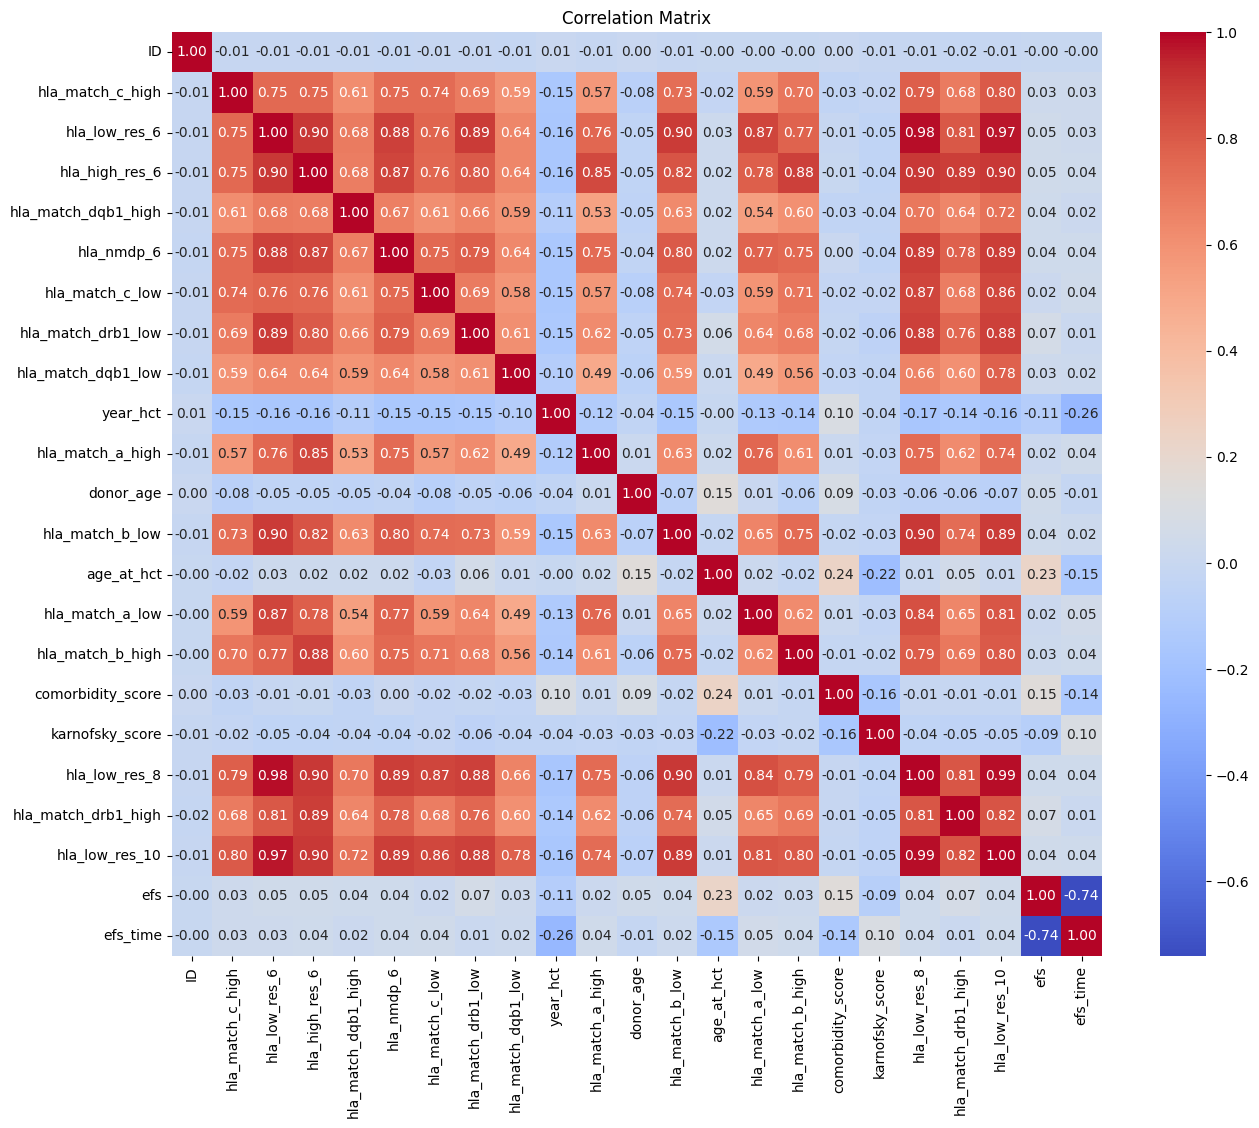

In [37]:
corr = train_df_filtered[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(15, 12))  # Adjust the size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


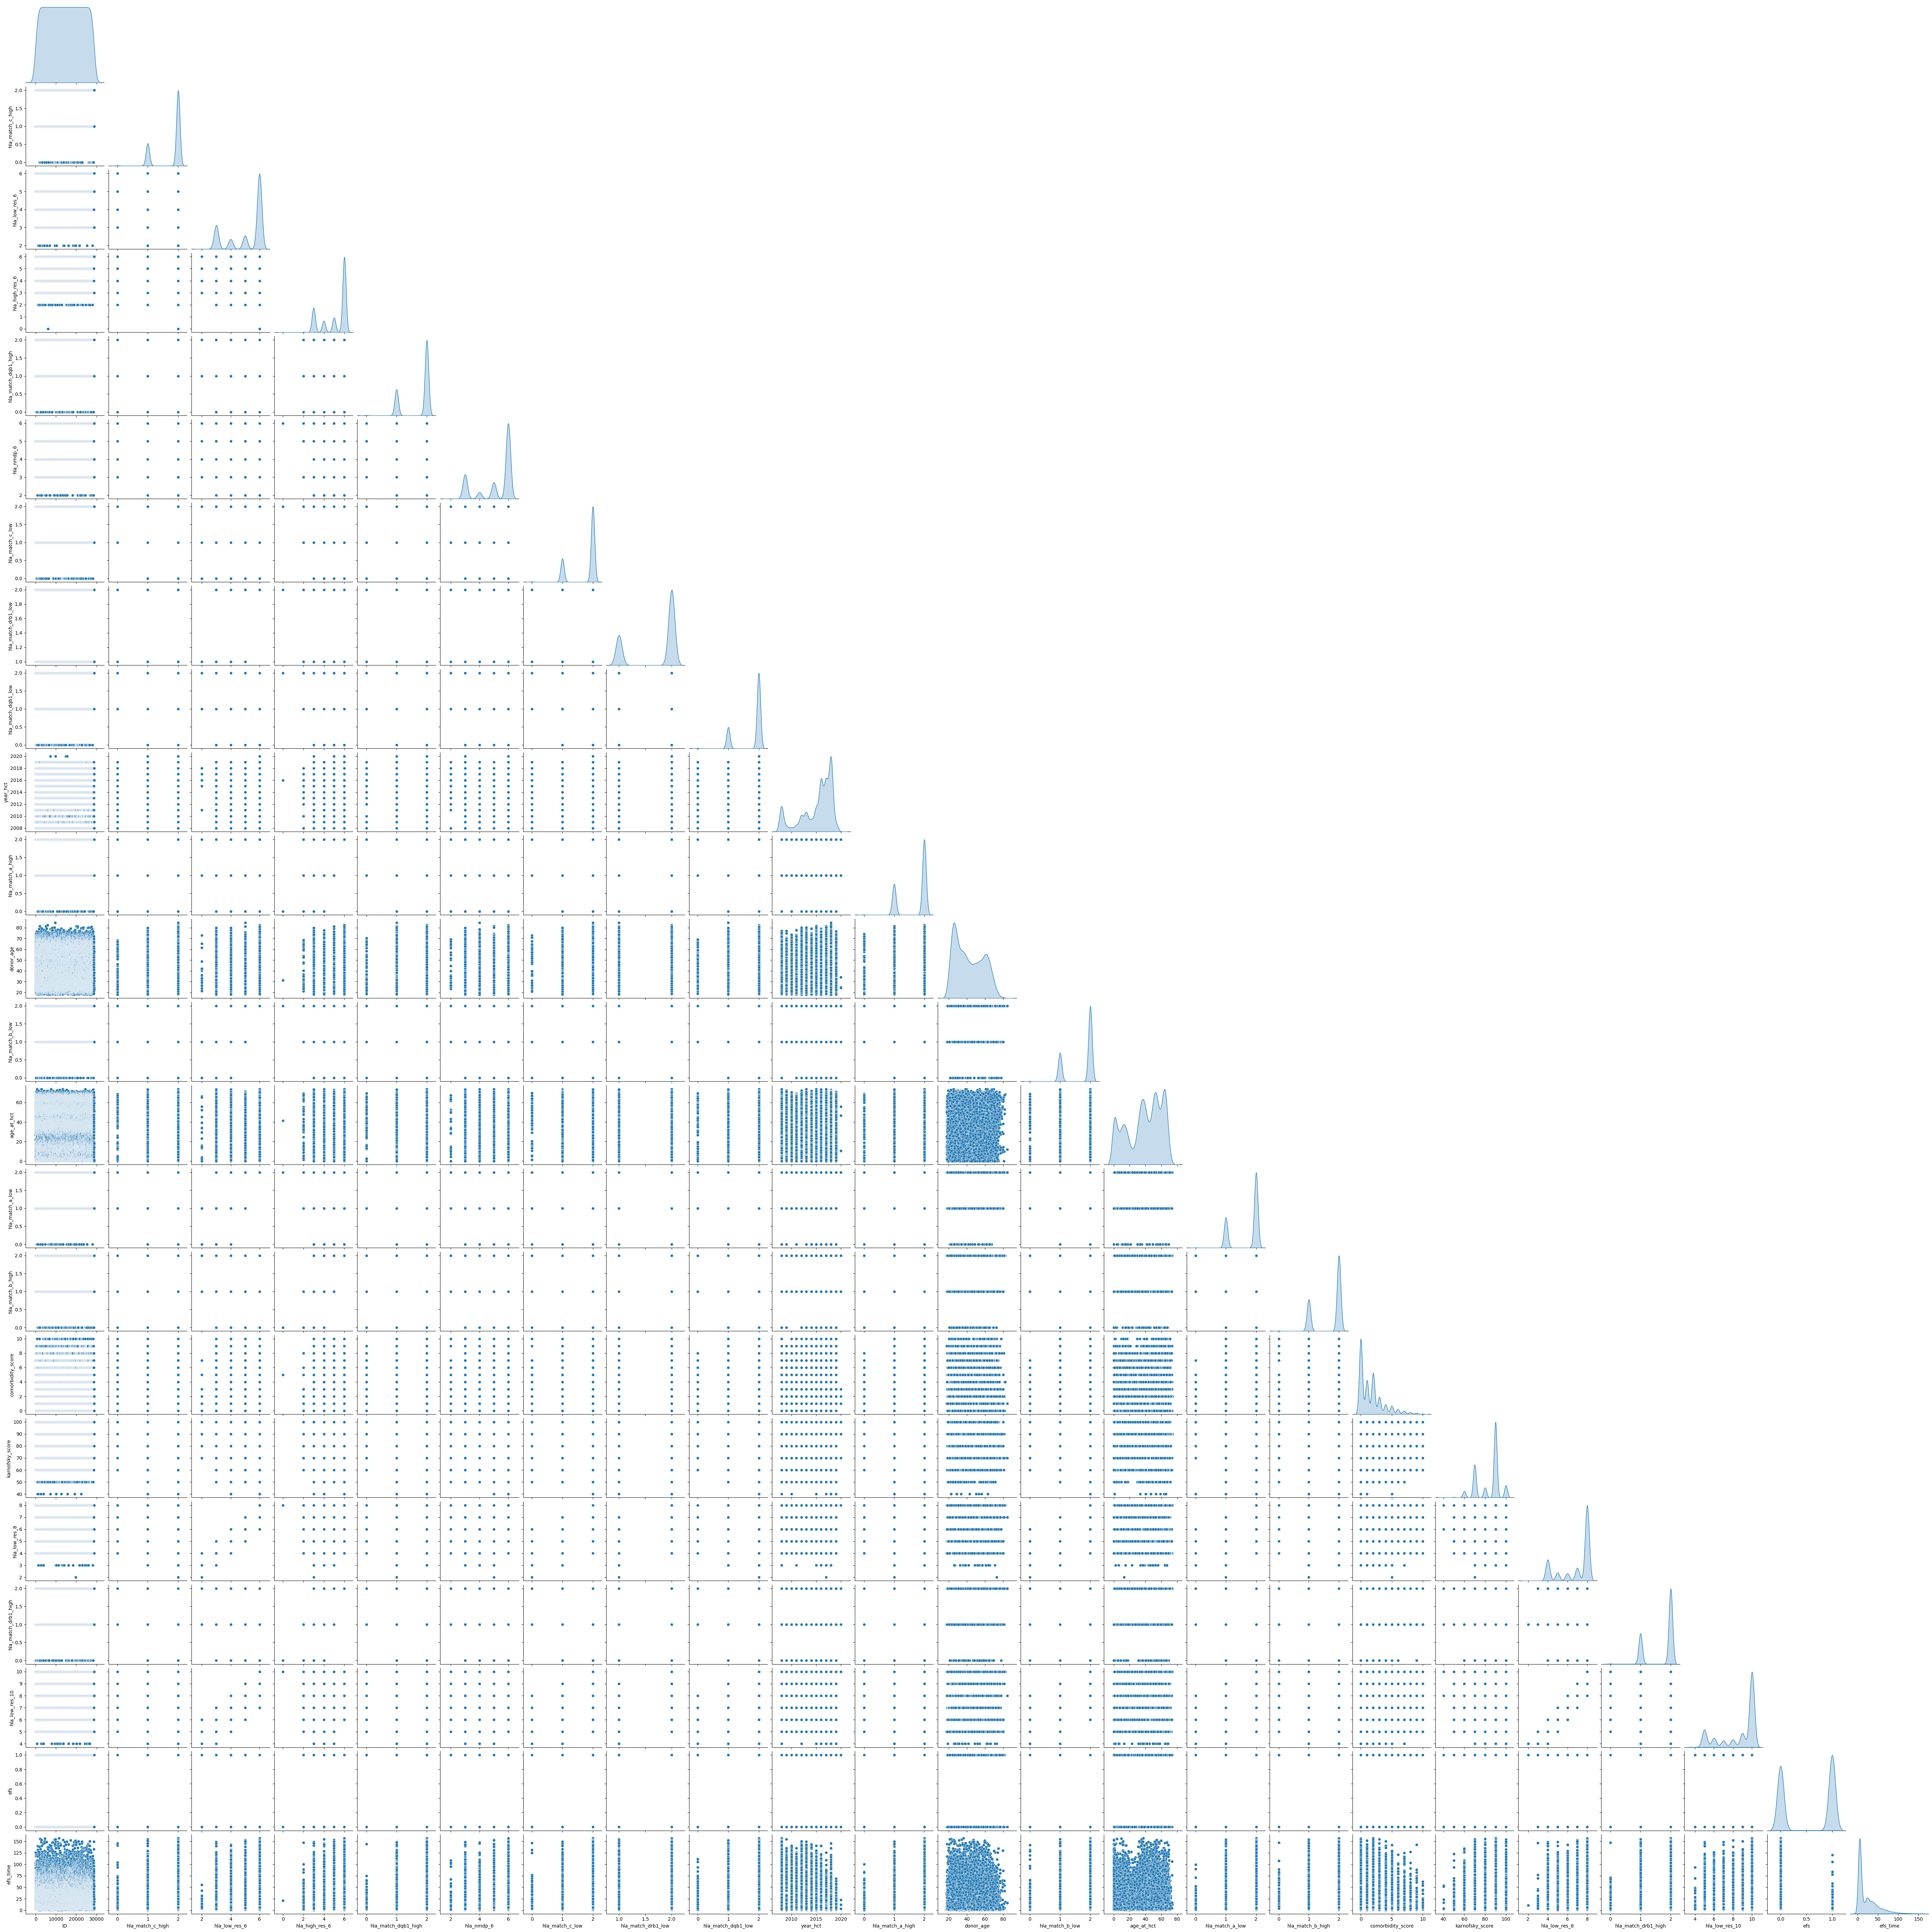

In [38]:
# Pairplot
sns.pairplot(train_df_filtered[numeric_columns], diag_kind="kde", kind="scatter", corner=True)

In [101]:
# before preprocessing, drop any columns that wont be used at all and sort into x and y
# Going to drop these columns from the data
columns_to_drop = ['efs','efs_time','cmv_status'] # Should go back and add the cmv status 

# Dynamically drop columns if they exist
x_train = train_df_filtered.drop(columns=[col for col in columns_to_drop if col in train_df.columns])
y_train = train_df_filtered['efs']

x_test = test_df_filtered.drop(columns=[col for col in columns_to_drop if col in test_df.columns])
#y_test = test_df_filtered['efs'] # won't exist for a true test dataset

In [102]:
# now some preprocessing, lets first fill in missing data. do small imputation with just mean
# get new numeric columns for the new train data
numeric_train_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

# Will apply same mean impute based on train, apply to test
for col in numeric_train_cols:
    mean_value = x_train[col].mean()  # Calculate mean from train_df
    x_train[col] = x_train[col].fillna(mean_value)  # Impute in train_df
    x_test[col] = x_test[col].fillna(mean_value)  # Impute in test_df with the same mean

In [103]:
# next, standardize numeric values
scaler = StandardScaler()
x_train[numeric_train_cols] = scaler.fit_transform(x_train[numeric_train_cols])
x_test[numeric_train_cols] = scaler.transform(x_test[numeric_train_cols])

In [104]:
# last, lets dummy code the categorical variables and build up the final train and test data
categorical_train_cols = x_train.select_dtypes(include=['object', 'category']).columns

x_train_encoded = pd.get_dummies(x_train, columns=categorical_train_cols, drop_first=True)
x_test_encoded = pd.get_dummies(x_test, columns=categorical_train_cols, drop_first=True)

# Check if any cat coded variables are missing from test, if so, add them with 0
missing_dummy_cols = set(x_train_encoded.columns) - set(x_test_encoded.columns)

for cols in missing_dummy_cols:
    x_test_encoded[cols] = 0
    
# Re-align columns in x_test_encoded to match the order of x_train_encoded
x_test_encoded = x_test_encoded[x_train_encoded.columns]

# Lastly, lets clean up column names
x_train_encoded.columns = x_train_encoded.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)
x_test_encoded.columns = x_test_encoded.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)

In [105]:
# Do one final check to make sure data align
print(x_train_encoded.shape)
print(x_test_encoded.shape)

(28800, 120)
(3, 120)


In [106]:
# Lets make a model evaluation function
def model_evaluation(y_train_test, y_pred):
    # fit metrics
    r2 = r2_score(y_train_test, y_pred)
    mse = mean_squared_error(y_train_test, y_pred)
    mae = mean_absolute_error(y_train_test, y_pred)

    # print results
    print(f"R-squared: {r2:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")

In [107]:
# set inital regression model 
lr_model = LinearRegression()

# fit model 
lr_model.fit(x_train_encoded, y_train)

LinearRegression()

In [108]:
# evaluate fit
y_lm_pred_train = lr_model.predict(x_train_encoded)
model_evaluation(y_train, y_lm_pred_train)

R-squared: 0.173
Mean Squared Error (MSE): 0.206
Mean Absolute Error (MAE): 0.412


In [109]:
# Lets do a random forest now, seems best option for this question
# Step 1: Define hyperparameter grid
n_estimator_values = [50, 100, 200]  # Number of trees in the forest
max_depth_values = [None, 10, 20, 30]  # Maximum depth of the tree
max_features_values = ['auto', 'sqrt', 'log2']  # Number of features to consider at each split

# Step 2: Create the parameter grid
rf_param_grid = {
    'n_estimators': n_estimator_values,
    'max_depth': max_depth_values,
    'max_features': max_features_values
}

# Step 3: set up regressor
rf_regressor = RandomForestRegressor()

# Step 4: build the grid search model
rf_grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=rf_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-3,  # Use all available cores minus 2
    verbose=1  # Output progress
)

In [110]:
# fit the grid search
rf_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-3,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

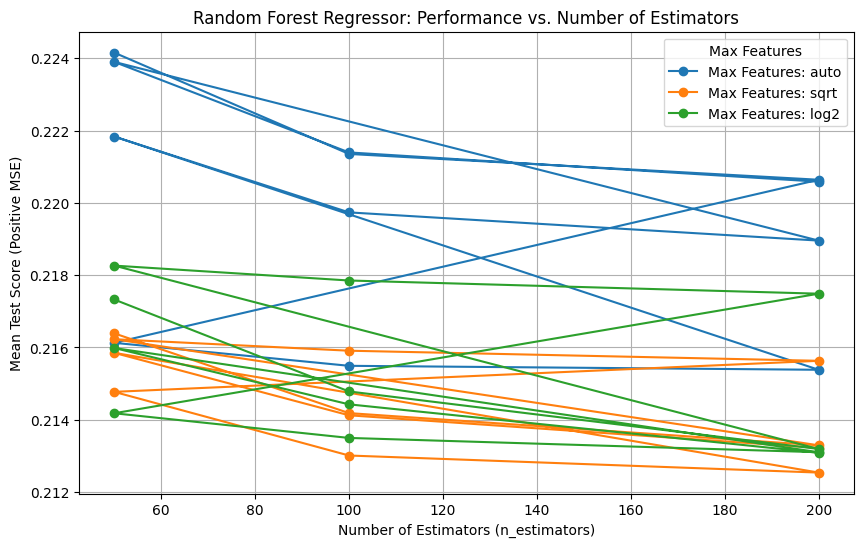

In [111]:
# Extract and plot results from GridSearchCV
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Plot performance for different max_features grouped by n_estimators
plt.figure(figsize=(10, 6))

for max_feature in max_features_values:  # max_features: ['auto', 'sqrt', 'log2']
    subset = rf_results[rf_results['param_max_features'] == max_feature]
    plt.plot(
        subset['param_n_estimators'], 
        -subset['mean_test_score'],  # Convert Negative MSE to Positive MSE
        marker='o', 
        label=f'Max Features: {max_feature}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (Positive MSE)')
plt.title('Random Forest Regressor: Performance vs. Number of Estimators')
plt.legend(title='Max Features')
plt.grid()
plt.show()

In [112]:
# Get the best parameters
best_n_estimator_value = rf_grid_search.best_params_['n_estimators']
best_max_depth_value = rf_grid_search.best_params_['max_depth']
best_max_features_value = rf_grid_search.best_params_['max_features']

# Print the best values
print(f"Best n_estimators: {best_n_estimator_value}")
print(f"Best max_depth: {best_max_depth_value}")
print(f"Best max_features: {best_max_features_value}")

Best n_estimators: 200
Best max_depth: 20
Best max_features: sqrt


In [113]:
# fit final model using the best param
best_rf_regressor = RandomForestRegressor(
    n_estimators=best_n_estimator_value,
    max_depth=best_max_depth_value,
    max_features=best_max_features_value
)

best_rf_regressor.fit(x_train_encoded, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=200)

In [114]:
# Model evaluation
y_rf_pred_train = best_rf_regressor.predict(x_train_encoded)

# evaluate model
model_evaluation(y_train, y_rf_pred_train)

R-squared: 0.607
Mean Squared Error (MSE): 0.098
Mean Absolute Error (MAE): 0.288


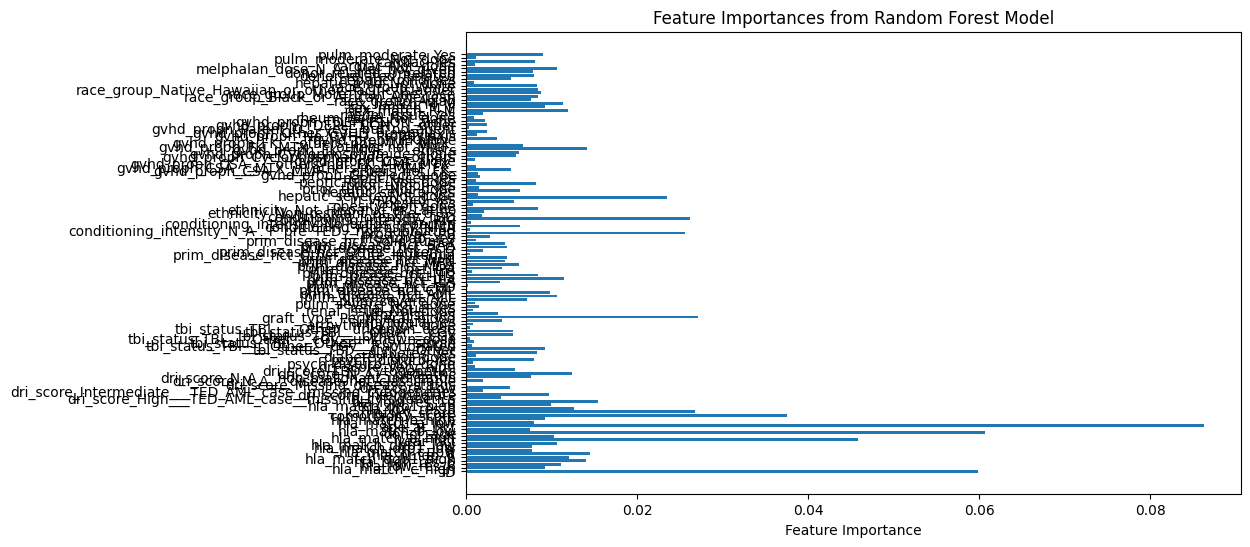

In [130]:
# Get feature importances from the best model
feature_importances = best_rf_regressor.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(x_train_encoded.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest Model')
plt.show()

In [124]:
# Step 1: Define hyperparameter grid for LightGBM
num_leaves_values = [25, 50, 100]  # Number of leaves in one tree
learning_rate_values = [0.01, 0.05, 0.1]  # Learning rate
n_estimators_values = [50, 100, 200]  # Number of boosting iterations (trees)

# Step 2: Create the parameter grid
lgb_param_grid = {
    'num_leaves': num_leaves_values,
    'learning_rate': learning_rate_values,
    'n_estimators': n_estimators_values
}

# Step 3: Set up regressor
lgb_regressor = lgb.LGBMRegressor()

# Step 4: Build the grid search model
lgb_grid_search = GridSearchCV(
    estimator=lgb_regressor,
    param_grid=lgb_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-3,  # Use all available cores
    verbose=1  # Output progress
)

In [125]:
# Step 5: Fit the grid search to find the best parameters
lgb_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 118
[LightGBM] [Info] Start training from score 0.539306


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-3,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [25, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

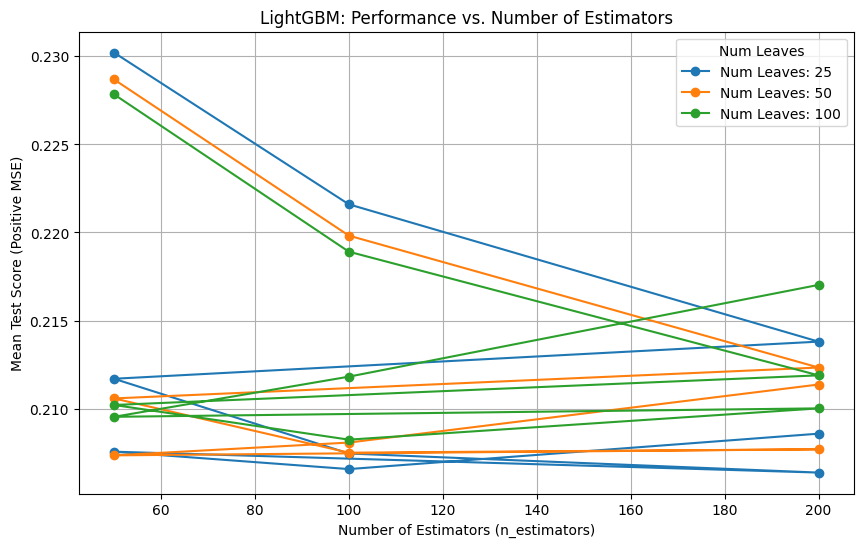

In [126]:
# Extract and plot results from GridSearchCV for LightGBM
lgb_results = pd.DataFrame(lgb_grid_search.cv_results_)

# Plot performance for different num_leaves grouped by n_estimators
plt.figure(figsize=(10, 6))

for num_leaves in num_leaves_values:  # num_leaves: [31, 50, 100]
    subset = lgb_results[lgb_results['param_num_leaves'] == num_leaves]
    plt.plot(
        subset['param_n_estimators'], 
        -subset['mean_test_score'],  # Convert Negative MSE to Positive MSE
        marker='o', 
        label=f'Num Leaves: {num_leaves}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (Positive MSE)')
plt.title('LightGBM: Performance vs. Number of Estimators')
plt.legend(title='Num Leaves')
plt.grid()
plt.show()

In [127]:
# Get the best parameters
best_lgb_num_leaves_value = lgb_grid_search.best_params_['num_leaves']
best_lgb_learning_rate_value = lgb_grid_search.best_params_['learning_rate']
best_lgb_n_estimators_value = lgb_grid_search.best_params_['n_estimators']

print(f"Best num_leaves: {best_lgb_num_leaves_value}")
print(f"Best learning_rate: {best_lgb_learning_rate_value}")
print(f"Best n_estimators: {best_lgb_n_estimators_value}")

Best num_leaves: 25
Best learning_rate: 0.05
Best n_estimators: 200


In [128]:
# Step 8: Fit the final model using the best parameters from grid search
best_lgb_regressor = lgb.LGBMRegressor(
    num_leaves=best_lgb_num_leaves_value,
    learning_rate=best_lgb_learning_rate_value,
    n_estimators=best_lgb_n_estimators_value
)

best_lgb_regressor.fit(x_train_encoded, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 118
[LightGBM] [Info] Start training from score 0.539306


LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=25)

In [129]:
# Model evaluation
y_lgb_pred_train = best_lgb_regressor.predict(x_train_encoded)

# evaluate model
model_evaluation(y_train, y_lgb_pred_train)

R-squared: 0.258
Mean Squared Error (MSE): 0.184
Mean Absolute Error (MAE): 0.391
